#### Code demonstration
----
Watson - recorded from PFC as rats slept

Goal: Extract and understand the data as stored in the NWB format, and housed on the DANDIhub

Analysis: Visualize the data and the shapes of the variables. Ran a power analysis, extracted power in the theta range over time, then performed linear regression

----
Processing variable contains awake and sleep data

#### Define dandiset
This is a dataset stored online

In [1]:
# dandiset ID
dandiset_id = '000041'

# libraries
import pynwb
import requests
from nwbwidgets import nwb2widget
from pynwb import NWBHDF5IO
import pandas
import numpy as np

#### Define functions to support streaming

In [2]:
def _search_assets(url, filepath):
    response = requests.request("GET", url, headers={"Accept": "application/json"}).json() 
    
    for asset in response["results"]:
        if filepath == asset["path"]:
            return asset["asset_id"]
    
    if response.get("next", None):
        return _search_assets(response["next"], filepath)
    
    raise ValueError(f'path {filepath} not found in dandiset {dandiset_id}.')

def get_asset_id(dandiset_id, filepath):
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/"
    return _search_assets(url, filepath)

def get_s3_url(dandiset_id, filepath):
    """Get the s3 location for any NWB file on DANDI"""

    asset_id = get_asset_id(dandiset_id, filepath)
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/{asset_id}/download/"
    
    s3_url = requests.request(url=url, method='head').url
    if '?' in s3_url:
        return s3_url[:s3_url.index('?')]
    return s3_url

#### Stream with DANDI to get data
Here, we want to extract the dataset into something we can use

In [3]:
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
import os # import os

# lets get all sessions for each rat
with DandiAPIClient() as client:
    
    # get dandiset using the ID code
    dandiset = client.get_dandiset(dandiset_id,'draft')
    
    # list splits the "zipped" generator file
    assets   = list(dandiset.get_assets())
    
    # list comprehension
    rats = {os.path.split(x.path)[0] for x in assets} # list comprehension, for loop, {} if unique

    # actually just work with sessions for now and call it a day
    sessions = [x.path for x in assets]
    #print(sessions)

    #asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    #s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

-----
#### Explore data

In [6]:
# using the rats variables, organize your data
print("This variable describes a high level organization of data, each output is a rats name that can be indexed")
rats

This variable describes a high level organization of data, each output is a rats name that can be indexed


{'sub-BWRat17',
 'sub-BWRat18',
 'sub-BWRat19',
 'sub-BWRat20',
 'sub-BWRat21',
 'sub-Bogey',
 'sub-Dino',
 'sub-Rizzo',
 'sub-Splinter',
 'sub-Templeton'}

In [7]:
print("Here is another feature of the data. Each rat contributed multiple sessions of data")
sessions

Here is another feature of the data. Each rat contributed multiple sessions of data


['sub-BWRat17/sub-BWRat17_ses-BWRat17-121912_ecephys.nwb',
 'sub-BWRat17/sub-BWRat17_ses-BWRat17-121712_ecephys.nwb',
 'sub-BWRat18/sub-BWRat18_ses-BWRat18-020513_ecephys.nwb',
 'sub-BWRat19/sub-BWRat19_ses-BWRat19-032413_ecephys.nwb',
 'sub-BWRat19/sub-BWRat19_ses-BWRat19-032513_ecephys.nwb',
 'sub-BWRat20/sub-BWRat20_ses-BWRat20-101013_ecephys.nwb',
 'sub-BWRat20/sub-BWRat20_ses-BWRat20-101513_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121613_ecephys.nwb',
 'sub-Bogey/sub-Bogey_ses-Bogey-012615_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121813_ecephys.nwb',
 'sub-BWRat21/sub-BWRat21_ses-BWRat21-121113_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-061814_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072314_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072114_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-061914_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-072414_ecephys.nwb',
 'sub-Dino/sub-Dino_ses-Dino-062014_ecephys.nwb',
 'sub-Rizzo/sub-Rizzo_ses-Rizzo-022715_ecephys.nwb',
 'su

-----
#### Diving into the data
Lets choose a session and extract data from the NWB dict

In [10]:
# select 1 session for now to get code working
tempAssetID = sessions[0]
asset_id = get_asset_id(dandiset_id, tempAssetID) # this is the URL for download
s3_path  = get_s3_url(dandiset_id, tempAssetID) # this is the path to streaming
#print(asset_id)

# use the "Read Only S3" (ros3) driver to stream data directly from DANDI (or any other S3 location)
io = NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3')

# read nwb file according to the s3 bucket path
nwb = io.read()

#Get the fields within the NWB file
nwbFields = nwb.fields

# read out the nwb file as it is a dict
nwbFile = nwb.electrodes['location'].data[:]
#nwbFile = nwb.intervals['epochs']
regions = list(nwbFile)


------
Lets examine the structure and data types of our imported and extracted data "nwb"
- This includes metadata

In [11]:
# lets visualize the nwb dataset
nwb

root pynwb.file.NWBFile at 0x140177379604080
Fields:
  devices: {
    implant <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    shank1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank2 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank3 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank4 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank5 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank6 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank7 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank8 <class 'pynwb.ecephys.ElectrodeGroup'>,
    shank9 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experimenter: ['Brendon Watson']
  file_create_date: [datetime.datetime(2020, 10, 3, 13, 49, 41, 955624, tzinfo=tzoffset(None, -14400))]
  identifier: BWRat17_121912
  institution: NYU
  lab: Buzsaki
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ecephys <class 'pynwb.base.ProcessingModule'>
  }
  related_publ

------
Here is a widget used to explore the data in a user friendly manner

In [12]:
nwb2widget(nwb)

-----
#### Getting data into some manageable format

In [13]:
# get behavioral data into dataframe
df_behavior = nwb.processing['behavior']['states'].to_dataframe()
df_behavior.shape

(71, 3)

Note that what you see below is simplified.

You could also do the following (which closely resembles dict organization):

`nwb.processing['ecephys'].data_interfaces['LFP'].electrical_series['lfp']`

Extracting data - this may take a few minutes...

In [14]:
# get lfp data out from just 1 shank
lfpData_s1 = nwb.processing['ecephys']['LFP']['lfp'].data[:,0:8]

In [15]:
lfpData_s1.shape

(8168375, 8)

In [16]:
# get the sampling rate of LFP - make sure this is an int-type (rounded, whole number) for indexing
srate_lfp = nwb.processing['ecephys']['LFP']['lfp'].rate.astype(int)
type(srate_lfp)

numpy.int64

Make a temporary variable in order to visualize the signal

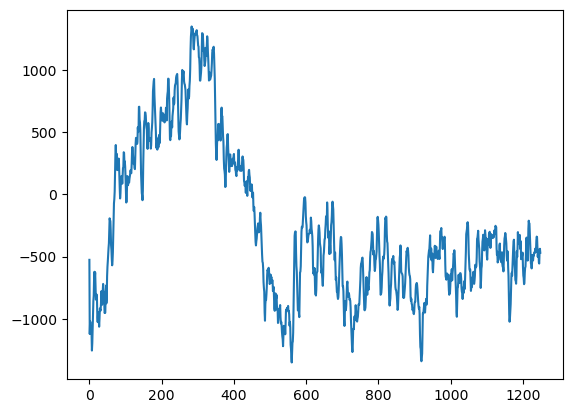

In [18]:
exData = lfpData_s1[0:1250-1,0]
# plot example trace
import matplotlib.pyplot as plt
plt.plot(exData)

In [20]:
# calculate coherence over moving window
amountData = srate_lfp*120 # 120 seconds
slData = lfpData_s1[0:amountData-1,1]
slData

array([ -470, -1016,  -903, ...,   587,   543,   488], dtype=int16)

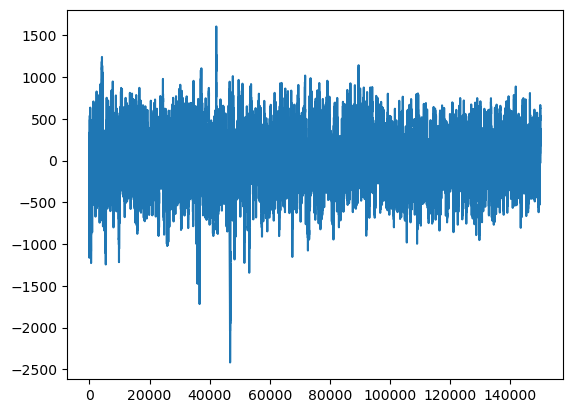

In [21]:
# notice that this plot has some noise peaks, I'm ignoring them for now
plt.plot(slData)

Lets work on preprocessing the signal

In [26]:
# load in library for power analysis
from scipy.signal import welch

# run power spectrum using 1.25s increments over .25s steps
amountTime = (srate_lfp*1.5).astype(int)
tempData = slData[0:amountTime-1]

# power spectrum
f,Ptemp = welch(tempData,srate_lfp.astype(float),nperseg=1000)

# restrict data to 1-50hz for plot proofing
#f[f>1]
idxspec = np.where((f>1) & (f<100))
fSpec = f[idxspec]
PSpec = Ptemp[idxspec]

# log10 transform
PSpecLog = np.log10(PSpec)

Text(0.5, 1.0, '6-9hz theta oscillation')

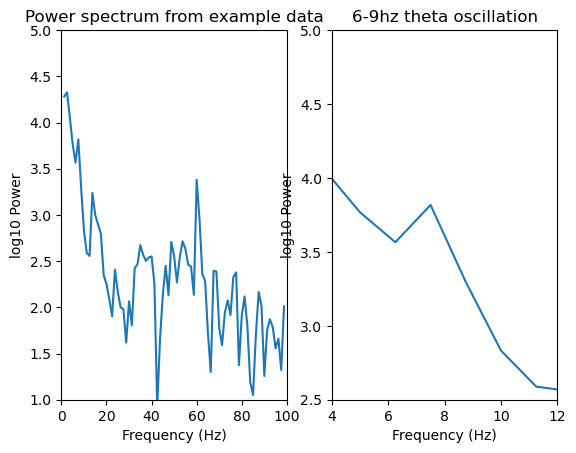

In [27]:
#plt.plot(dataDet)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(fSpec,PSpecLog)
ax1.set_xlim([0, 100])
ax1.set_ylim([1,5])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('log10 Power')
ax1.set_title('Power spectrum from example data')

ax2.plot(fSpec,PSpecLog)
ax2.set_xlim([4,12])
ax2.set_ylim([2.5,5])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('log10 Power')
ax2.set_title('6-9hz theta oscillation')

----
#### Moving window power spectral estimations

----

In [28]:
windowSize = (srate_lfp*1.5).astype(int)
windowStep = (srate_lfp*0.2).astype(int)
totalDataSize = len(slData)
#print(windowStep)

# make a looper variable from 0, every 200ms, to end of data
looperVar = np.arange(0,totalDataSize,windowStep-1)
#looperVar

----
#### Get the mean and std of the distribution to define movement artifacts
----

In [29]:
# get mean and std of entire distribution of dataset
from scipy.stats import zscore
zSlData = zscore(slData)

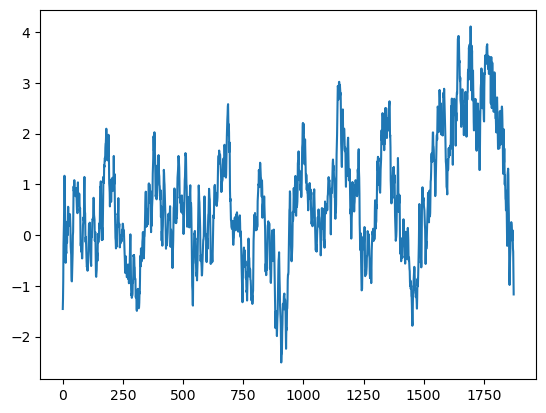

In [30]:
stepi = 10
#print([looperVar[stepi]:looperVar[stepi+1]])
temp = zSlData[looperVar[stepi]:looperVar[stepi]+windowSize]
plt.plot(temp)

In [31]:
(looperVar[0]+windowSize)-1

1874

In [32]:
range(len(looperVar))

range(0, 603)

----
#### Get theta power over time

In [35]:
powTheta = []
powDelta = []
powThetaAll = []
arrayAll = []
arrayTheta = []
for i in range(len(looperVar)):
    
    # get temp data
    tempData = slData[looperVar[i]:(looperVar[i]+windowSize)-1]

    if len(tempData) != ((looperVar[0]+windowSize)-1):
        continue

    # power spectrum
    f,Ptemp = welch(tempData,srate_lfp.astype(float),nperseg=1000)

    # restrict data to 1-50hz for plot proofing
    #f[f>1]
    idxspec = np.where((f>0) & (f<100))
    fSpec = f[idxspec]
    #print(f)
    PSpec = Ptemp[idxspec]

    # log10 transform
    PSpecLog = np.log10(PSpec) 
    #plt.plot(fSpec,PSpecLog)

    # now get theta out
    idxTheta = np.where((fSpec > 6) & (fSpec < 9))
    #print(f[idxTheta])
    Ptheta  = np.mean(PSpecLog[idxTheta])
    
    # get delta power
    idxDelta = np.where((fSpec > 1) & (fSpec < 4))
    Pdelta = np.mean(PSpecLog[idxDelta])
    
    # store data if theta > delta - actually this isn't the best way.
    # we should instead fit a line that assumes a 1/f distribution matching the 
    # power spectrum, then find instances when theta power is above 1std from the mean
    if Ptheta > Pdelta:
        powTheta.append(Ptheta)
        arrayTheta.append(PSpecLog)
    if Pdelta > Ptheta:
        powDelta.append(Pdelta)
    
    powThetaAll.append(powThetaAll)
    
    # hstack the array into a list
    arrayAll.append(np.hstack(PSpecLog))

# this array contains vertically concatenated
#arrayAll   = np.vstack(array)
arrayTheta = np.vstack(arrayTheta)
    

Text(0, 0.5, 'log10 prefrontal 6-9hz power')

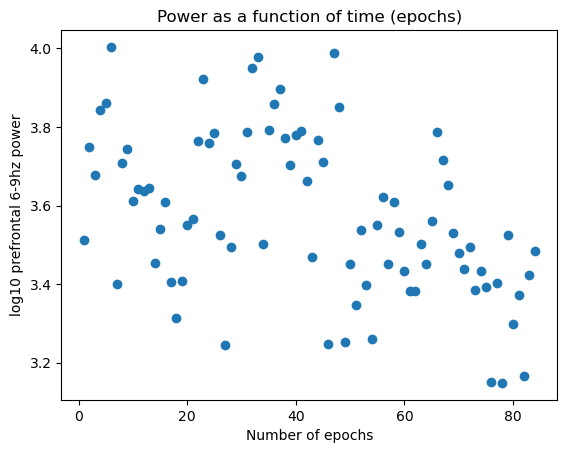

In [64]:
numEvents = np.linspace(1,len(powTheta),len(powTheta))
plt.scatter(numEvents,powTheta)
plt.title('Power as a function of time (epochs)')
plt.xlabel('Number of epochs')
plt.ylabel('log10 prefrontal 6-9hz power')

Lets fit a regression line to the dataset - Is Prefrontal theta power changing over the course of the behavioral recording?

List Comprehension: first, we need to get new variables that represent event counts and theta power

In [59]:
# convert our numEvents variable via list comprehension
eventTemp = [[i] for i in numEvents]
powTemp = [[i] for i in powTheta]

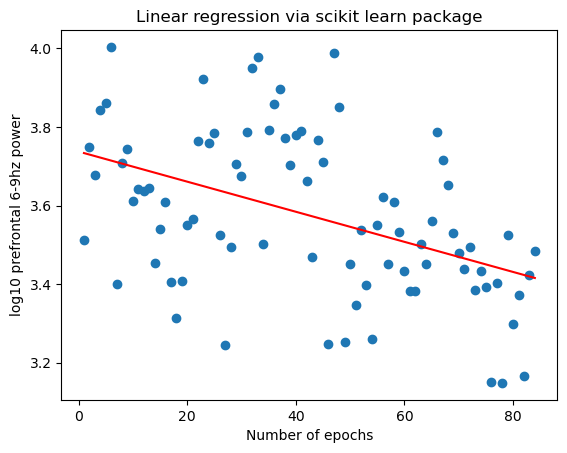

In [62]:
from sklearn.linear_model import LinearRegression

# Model initialization
reg = LinearRegression()

# Fit the data(train the model)
reg.fit(eventTemp, powTemp)

# Predict
y_pred = reg.predict(eventTemp)

# plot new fig
plt.scatter(eventTemp,powTemp)
plt.title('Linear regression via scikit learn package')
plt.xlabel('Number of epochs')
plt.ylabel('log10 prefrontal 6-9hz power')
plt.plot(numEvents, y_pred, color='r')
